In [1]:
pip install plotly ipywidgets -q

Note: you may need to restart the kernel to use updated packages.


In [14]:
import numpy as np
import torch
from transformers import ViTModel, ViTFeatureExtractor
import gudhi as gd
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial.distance import jensenshannon
import plotly.graph_objs as go
from PIL import Image
import ipywidgets as widgets


def get_attention_matrix(image, model, tokenizer, layer, head):
    inputs = tokenizer(images=[image], return_tensors="pt")
    outputs = model(**inputs, output_attentions=True)
    attention = outputs.attentions[layer][0, head].detach().cpu().numpy()
    return attention

def compute_persistence(attention_matrix):
    softmax_attention = np.exp(attention_matrix) / np.sum(np.exp(attention_matrix), axis=-1)[:, np.newaxis]
    distance_matrix = np.array([[jensenshannon(softmax_attention[i], softmax_attention[j]) for j in range(softmax_attention.shape[0])] for i in range(softmax_attention.shape[0])])
    
    rips_complex = gd.RipsComplex(distance_matrix=distance_matrix, max_edge_length=np.inf)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistence = simplex_tree.persistence(min_persistence=0.00001)
    return persistence, simplex_tree, distance_matrix

In [15]:
# Load pre-trained visual transformer model and tokenizer
tokenizer = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTModel.from_pretrained('google/vit-base-patch16-224')

# Image inputs
image1 = Image.open("heart.png")
image1 = image1.convert('RGB')

image2 = Image.open("heart2.png")
image2 = image2.convert('RGB')


# Choose a layer and head
layer = 11
head = 2

# Get attention matrices
attention_matrix1 = get_attention_matrix(image1, model, tokenizer, layer, head)
attention_matrix2 = get_attention_matrix(image2, model, tokenizer, layer, head)

# Compute persistence and simplex trees
persistence1, simplex_tree1, distance_matrix1 = compute_persistence(attention_matrix1)
persistence2, simplex_tree2, distance_matrix2 = compute_persistence(attention_matrix2)


/Users/amelieschreiber/vscode_projects/vision_persistent_homology/.conda/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at goo

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

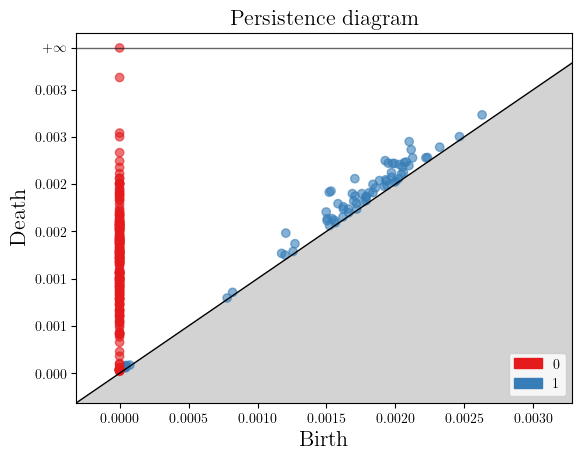

In [16]:
gd.plot_persistence_diagram(persistence1)

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

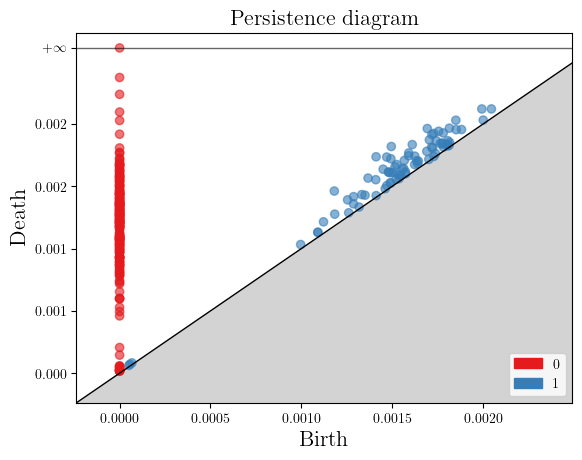

In [17]:
gd.plot_persistence_diagram(persistence2)

In [18]:
# Import necessary libraries
from scipy.spatial.distance import squareform
from gudhi.wasserstein import wasserstein_distance
import numpy as np

pd1 = np.array([point[1] for point in persistence1])
pd2 = np.array([point[1] for point in persistence2])

# Compute the Wasserstein distance
distance = wasserstein_distance(pd1, pd2)

In [19]:
print(distance)

0.02797723758963642
